# Recurrent recommender networks
## Trabalho final da disciplina de Introdução à Machine Learning - UFRJ 2022.2

Baseado no artigo [Wu, Chao-Yuan, et al. 'Recurrent recommender networks.' 2017.](https://dl.acm.org/doi/epdf/10.1145/3018661.3018689)

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
style.use('dark_background')

import tensorflow.compat.v1 as tf
import tensorflow.nn as nn

import sys
import time
import warnings

warnings.filterwarnings('ignore')

## Base de dados

In [2]:
ratings_titles = ['user_id', 'movie_id', 'rating', 'timestamp']

df = pd.read_table(
    'ratings.dat',
    sep = '::',
    header = None,
    names = ratings_titles,
    engine = 'python'
)

df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
print(f'O dataset possui {df.shape[0]} instâncias.')

O dataset possui 1000209 instâncias.


In [4]:
num_users = df['user_id'].nunique()
num_movies = df['movie_id'].nunique()

print(f'Dessas instâncias, temos {num_users} usuários, e {num_movies} filmes.')

Dessas instâncias, temos 6040 usuários, e 3706 filmes.


In [5]:
num_movies = max(df['movie_id'])

print(
    'Entretanto, os identificadores dos filmes não são sequencias, como os dos usuários, '
    'e por essa razão teve que ser alterado para o maior identificador existente no dataset.'
    '\nDo contrário, a célula de treinamento dá erro em relação aos índices dos arrays.'
    f'\nNúmero de filmes considerados é, então, igual à {num_movies}.'
)

Entretanto, os identificadores dos filmes não são sequencias, como os dos usuários, e por essa razão teve que ser alterado para o maior identificador existente no dataset.
Do contrário, a célula de treinamento dá erro em relação aos índices dos arrays.
Número de filmes considerados é, então, igual à 3952.


## Preparando o modelo LSTM

### Hiperparâmetros

In [6]:
HYPERPARAM = {
    'batch_size': 50,
    'hidden_size': 128,
    'out_size': 64,
    'n_step': 1,
    'learning_rate': 0.01,
    'verbose': 10
}

### Placeholders

In [7]:
tf.disable_eager_execution()

user_id = tf.placeholder(tf.int32, shape = [None, 1], name = 'user_id')
movie_id = tf.placeholder(tf.int32, shape = [None, 1], name = 'movie_id')
rating = tf.placeholder(tf.float32, shape = [None, 1], name = 'rating')
dropout = tf.placeholder(tf.float32, name = 'dropout')

### Camadas

#### User embedding layer & lookup

In [8]:
with tf.variable_scope('user_id_embedding', reuse = tf.AUTO_REUSE):

    embedding_user = tf.get_variable(
        name = 'embedding_users',
        shape = [num_users, HYPERPARAM['hidden_size']],
        initializer = tf.glorot_uniform_initializer()
    )

    user_id_layer = nn.embedding_lookup(embedding_user, user_id)
    user_id_layer = nn.relu(user_id_layer)

#### Movie embedding layer & lookup

In [9]:
with tf.variable_scope('movie_id_embedding', reuse = tf.AUTO_REUSE):

    embedding_movie = tf.get_variable(
        name = 'embedding_movie',
        shape = [num_movies, HYPERPARAM['hidden_size']],
        initializer = tf.glorot_uniform_initializer()
    )

    movie_id_layer = nn.embedding_lookup(embedding_movie, movie_id)
    movie_id_layer = nn.relu(movie_id_layer)

#### User feedforward layer

In [10]:
with tf.variable_scope('user_rnn_cell', reuse = tf.AUTO_REUSE):

    user_cell = tf.keras.layers.LSTMCell(HYPERPARAM['hidden_size'])
    user_input = tf.transpose(user_id_layer, [1, 0, 2])
    user_outputs, user_states = tf.nn.dynamic_rnn(user_cell, user_input, dtype = tf.float32)
    user_output = user_outputs[-1]

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


#### Movie feedforward layer

In [11]:
with tf.variable_scope('movie_rnn_cell', reuse = tf.AUTO_REUSE):

    movie_cell =  tf.keras.layers.LSTMCell(HYPERPARAM['hidden_size'])
    movie_input  = tf.transpose(movie_id_layer, [1, 0, 2])
    movie_outputs, movie_states = tf.nn.dynamic_rnn(movie_cell, movie_input, dtype = tf.float32)
    movie_output = movie_outputs[-1]

#### Previsão

In [12]:
with tf.variable_scope('pred_layer', reuse = tf.AUTO_REUSE):

    user_vector = tf.layers.dense(user_output, HYPERPARAM['out_size'], activation = None)
    movie_vector = tf.layers.dense(movie_output, HYPERPARAM['out_size'], activation = None)

    pred = tf.reduce_sum(tf.multiply(user_vector, movie_vector), axis = 1, keepdims = True)

### Loss e Otimizador
- Loss: erro quadrático médio
- Otimizador: ADAM

In [13]:
loss = tf.reduce_mean(tf.losses.mean_squared_error(rating, pred))
optimizer = tf.train.AdamOptimizer(HYPERPARAM['learning_rate']).minimize(loss)

## Treinando o modelo

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [15]:
train = df.values
length  = len(train)
batches = int(length/ HYPERPARAM['batch_size']) + 1

print(
    f"Teremos {batches} batches avaliando {HYPERPARAM['batch_size']} amostras cada.\n"
    f"{batches} (Total de batches) x {HYPERPARAM['batch_size']} (Amostras por batches) = "
    f"{batches * HYPERPARAM['batch_size']} =~ {df.shape[0]} (Tamanho do dataset)."
)

Teremos 20005 batches avaliando 50 amostras cada.
20005 (Total de batches) x 50 (Amostras por batches) = 1000250 =~ 1000209 (Tamanho do dataset).


In [16]:
start_time = time.perf_counter()

train_loss = []
predictions = []

for batch in range(batches):
    
    # Definindo limite superior e inferior dos índices para cada batch
    min_index = batch * HYPERPARAM['batch_size']
    max_index = min(length, (batch + 1) * HYPERPARAM['batch_size'])
    train_batch =  train[min_index : max_index]

    # user, movie, rating
    inputs  = np.array([
        (batch[0] - 1, batch[1] - 1, float(batch[2])) for batch in train_batch
    ])

    # Não é possível passar os placeholders, então usamos feed_dict  
    feed_dict = {
        user_id: np.expand_dims(inputs[:, 0], 1),
        movie_id: np.expand_dims(inputs[:, 1], 1),
        rating: np.expand_dims(inputs[:, 2], 1),
        dropout: 1.0
    }

    # Treinamento
    _, batch_loss = session.run([optimizer, loss], feed_dict = feed_dict)

    # Salvando valores de loss para futuro plot
    train_loss.append(batch_loss)

    # Criando DataFrame com as previsões
    prediction = session.run(pred, feed_dict = feed_dict)
    df_prediction = {
        'Actual': inputs[:, 2],
        'Predicted': prediction.reshape(-1)
    }
    predictions.append(df_prediction)    

    # Print para debug que evita logs longos
    if HYPERPARAM['verbose'] and (batch % HYPERPARAM['verbose'] == 0):
        sys.stdout.write(
            '\rBatch #{} de {}: loss = {}'.format(
                batch, batches, np.sqrt(np.mean(train_loss[-HYPERPARAM['batch_size']:]))
            )
        )
        sys.stdout.flush()


total_time = time.perf_counter() - start_time
print(f'\nLSTM levou um total de {total_time} segundos = {total_time/ 60} minutos.')

Batch #20000 de 20005: loss = 0.9692320227622986
LSTM levou um total de 772.999392 segundos = 12.8833232 minutos.


## Visualizando loss

### Todas os batches

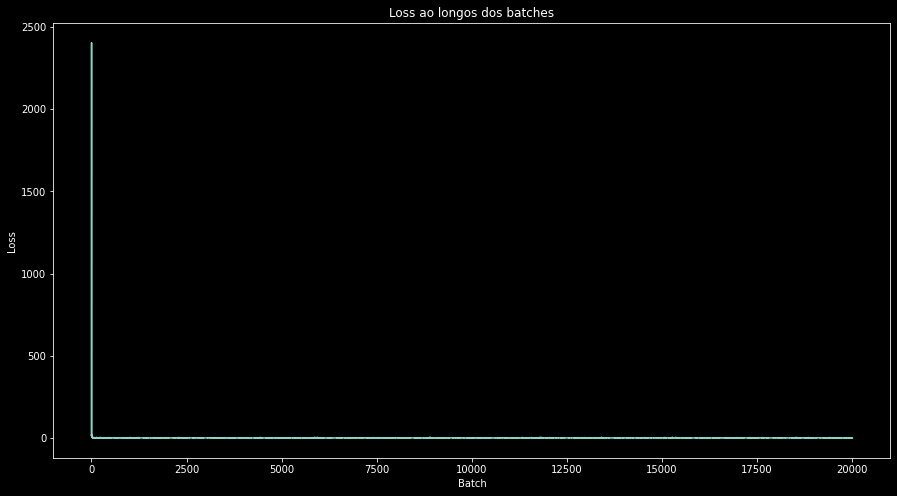

In [17]:
plt.figure(figsize = (15, 8))
plt.plot(train_loss)

plt.title('Loss ao longos dos batches')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.show()

### A partir do batch 2500

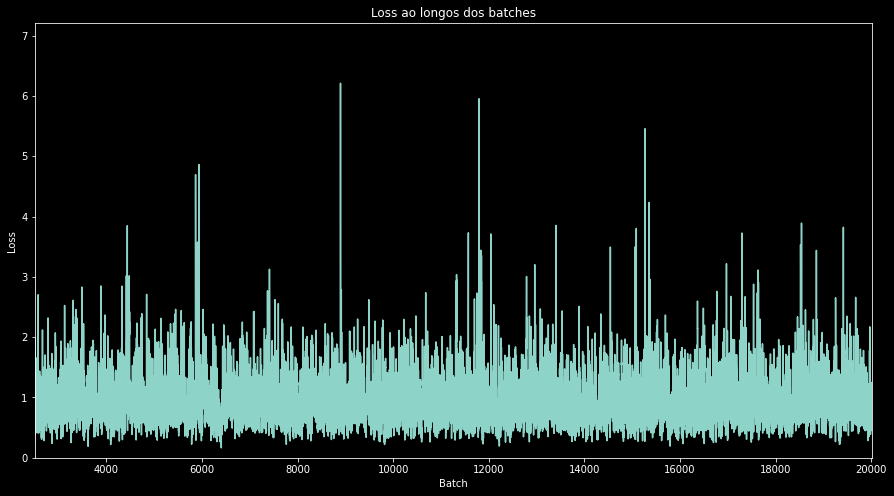

In [18]:
plt.figure(figsize = (15, 8))
plt.plot(train_loss)

plt.title('Loss ao longos dos batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.axis([2500, len(train_loss), 0, max(train_loss[2500:]) + 1])

plt.show()

## Tabela com previsões

In [34]:
df_prediction = pd.DataFrame(predictions[-1000:])
df_prediction = df_prediction.explode('Actual').explode('Predicted').reset_index(drop = True)
df_prediction.head(10)

,Actual,Predicted
0,4.0,3.527369
1,4.0,3.478723
2,4.0,4.095185
3,4.0,4.36827
4,4.0,4.00599
5,4.0,4.139043
6,4.0,3.841781
7,4.0,4.198711
8,4.0,3.487641
9,4.0,3.868276


In [35]:
df_prediction.to_csv('lstm_prediction.csv', index = False)